## Overview

This notebook has 4 major sections. If you want to doive into a partiuclar section - plecase use the below links -
1. [Data Cleaning](#1.-Data-Cleaning)
3. [Data Analysis](#2.-Data-Analysis)
4. [Defining bot clicks](#3.-Defining-bot-clicks)
5. [Building ML model](#4.-Building-ML-model)

### Import packages

In [1]:
import pandas as pd
import urllib.parse
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import duckdb
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    roc_curve,
    auc
)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 1. Data Cleaning

## Clean url column

In [2]:
raw_data = pd.read_csv('bot-hunter-dataset.tsv', sep='\t', header=None, names=['date_time', 'server_location', 'browser', 'device', 'url', 'empty_column'])
raw_data.drop('empty_column', axis=1, inplace=True)
raw_data['json_url']=raw_data.apply(lambda x: urllib.parse.parse_qs(urllib.parse.urlparse(x['url']).query), axis=1)

In [3]:
raw_data.head()

,date_time,server_location,browser,device,url,json_url
0,2019-12-02 18:52:42,Earth,Edge,Android,/ad_click?n=1&f=1&d=www.amazon.ca&sld=0&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=5314&q=sh%20rug%20gasmaker%20matty&ct=CA&kl=wt-wt&kp=-1,"{'n': ['1'], 'f': ['1'], 'd': ['www.amazon.ca'], 'sld': ['0'], 'st': ['mobile_search_intl'], 'nt': ['0'], 'r': ['0'], 'adx': ['none'], 'adx_name': ['none'], 'ttc': ['5314'], 'q': ['sh rug gasmaker matty'], 'ct': ['CA'], 'kl': ['wt-wt'], 'kp': ['-1']}"
1,2019-12-02 16:30:07,Earth,Edge,Android,/ad_click?n=1&f=1&d=regus.ca&sld=0&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=2485&q=poky%20gloze%20bedikah%20gangliac&ct=CA&kl=wt-wt&kp=-1,"{'n': ['1'], 'f': ['1'], 'd': ['regus.ca'], 'sld': ['0'], 'st': ['mobile_search_intl'], 'nt': ['0'], 'r': ['0'], 'adx': ['none'], 'adx_name': ['none'], 'ttc': ['2485'], 'q': ['poky gloze bedikah gangliac'], 'ct': ['CA'], 'kl': ['wt-wt'], 'kp': ['-1']}"
2,2019-12-02 13:04:19,Mars,Safari,Android,/ad_click?n=1&f=1&d=www.heathrowexpress.com&sld=1&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=2983&q=trickily%20voetian&ct=SE&kl=se-sv&kp=-1,"{'n': ['1'], 'f': ['1'], 'd': ['www.heathrowexpress.com'], 'sld': ['1'], 'st': ['mobile_search_intl'], 'nt': ['0'], 'r': ['0'], 'adx': ['none'], 'adx_name': ['none'], 'ttc': ['2983'], 'q': ['trickily voetian'], 'ct': ['SE'], 'kl': ['se-sv'], 'kp': ['-1']}"
3,2019-12-02 07:35:56,Mars,Chrome,Android,/ad_click?n=1&f=1&d=www.heathrowexpress.com&sld=1&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=1046&q=trickily%20voetian&ct=GB&kl=wt-wt&kp=-2,"{'n': ['1'], 'f': ['1'], 'd': ['www.heathrowexpress.com'], 'sld': ['1'], 'st': ['mobile_search_intl'], 'nt': ['0'], 'r': ['0'], 'adx': ['none'], 'adx_name': ['none'], 'ttc': ['1046'], 'q': ['trickily voetian'], 'ct': ['GB'], 'kl': ['wt-wt'], 'kp': ['-2']}"
4,2019-12-02 08:59:14,Earth,Chrome,Android,/ad_click?n=1&f=1&d=www.greyhound.com&sld=0&st=mobile_search_intl&nt=0&r=0&adx=none&adx_name=none&ttc=19057&q=stylidium&ct=CA&kl=wt-wt&kp=-1,"{'n': ['1'], 'f': ['1'], 'd': ['www.greyhound.com'], 'sld': ['0'], 'st': ['mobile_search_intl'], 'nt': ['0'], 'r': ['0'], 'adx': ['none'], 'adx_name': ['none'], 'ttc': ['19057'], 'q': ['stylidium'], 'ct': ['CA'], 'kl': ['wt-wt'], 'kp': ['-1']}"


## No Na's in raw data

In [4]:
raw_data.isna().sum()

date_time          0
server_location    0
browser            0
device             0
url                0
json_url           0
dtype: int64

### These are all the possible attributes in url- we will define them below in separate columns

In [5]:
def get_unique_json_keys(df, col):
    all_keys = Counter()
    for val in df[col]:
        all_keys.update(val.keys())
    return all_keys

get_unique_json_keys(raw_data, 'json_url')

Counter({'n': 15627,
         'd': 15627,
         'sld': 15627,
         'st': 15627,
         'nt': 15627,
         'r': 15627,
         'adx': 15627,
         'adx_name': 15627,
         'ttc': 15627,
         'q': 15625,
         'ct': 15620,
         'kl': 15620,
         'kp': 15620,
         'f': 15591,
         'bkl': 2068,
         'lsexp1': 1514,
         'om': 519,
         'atb': 270,
         'atbva': 41,
         'va': 12,
         'atbexp': 6})

In [6]:
# source of param names - https://duckduckgo.com/duckduckgo-help-pages/settings/params
def clean_url(url: str) -> dict:
    parsed = urllib.parse.urlparse(url)
    params = urllib.parse.parse_qs(parsed.query)
    params = {k: v[0] for k, v in params.items()}

    mapped = {
        "n": params.get("n"),
        "clicked_ad": params.get("d"),
        "slot_id": params.get("sld"),
        "source_type": params.get("st"),
        "network_type": params.get("nt"),
        "r": params.get("r"),
        "ad_exchange": params.get("adx"),
        "ad_exchange_name": params.get("adx_name"),
        "time_to_click": params.get("ttc"),
        "search_term": params.get("q"),
        "country": params.get("ct"),
        "region": params.get("kl"),
        "safe_search": params.get("kp"),
        "f": params.get("f"),
        "bkl": params.get("bkl"),
        "lsexp1": params.get("lsexp1"),
        "om": params.get("om"),
        "atb": params.get("atb"),
        "atbva": params.get("atbva"),
        "va": params.get("va"),
        "atbexp": params.get("atbexp"),
}
    return mapped

raw_data['clean_json_url']=raw_data.apply(lambda x: clean_url(x['url']), axis=1)

In [7]:
data = pd.concat([raw_data[['date_time', 'server_location', 'browser', 'device']], pd.json_normalize(raw_data['clean_json_url'])],axis = 1) 

In [8]:
data.drop_duplicates(inplace=True)

## Clean data

In [9]:
data.head()

,date_time,server_location,browser,device,n,clicked_ad,slot_id,source_type,network_type,r,ad_exchange,ad_exchange_name,time_to_click,search_term,country,region,safe_search,f,bkl,lsexp1,om,atb,atbva,va,atbexp
0,2019-12-02 18:52:42,Earth,Edge,Android,1,www.amazon.ca,0,mobile_search_intl,0,0,none,none,5314,sh rug gasmaker matty,CA,wt-wt,-1,1,None,None,None,None,None,None,None
1,2019-12-02 16:30:07,Earth,Edge,Android,1,regus.ca,0,mobile_search_intl,0,0,none,none,2485,poky gloze bedikah gangliac,CA,wt-wt,-1,1,None,None,None,None,None,None,None
2,2019-12-02 13:04:19,Mars,Safari,Android,1,www.heathrowexpress.com,1,mobile_search_intl,0,0,none,none,2983,trickily voetian,SE,se-sv,-1,1,None,None,None,None,None,None,None
3,2019-12-02 07:35:56,Mars,Chrome,Android,1,www.heathrowexpress.com,1,mobile_search_intl,0,0,none,none,1046,trickily voetian,GB,wt-wt,-2,1,None,None,None,None,None,None,None
4,2019-12-02 08:59:14,Earth,Chrome,Android,1,www.greyhound.com,0,mobile_search_intl,0,0,none,none,19057,stylidium,CA,wt-wt,-1,1,None,None,None,None,None,None,None


# 2. Data Analysis

## EDA
1. There are several parameters in the URL such as r, f, bkl, lspexp1, om, atb, atbva, va, and atbexp—for which I couldn’t find clear definitions. Given the time constraints, I will not explore these further as part of this project.
2. All data is from mobile device
3. Interesting wt-wt is the most common region which stands for "No region"
4. Most traffic is from android device
5. Only 1 % traffic has safe search ON
6. All data is for a single day: 2019-12-02

In [10]:
data['date_time'] = pd.to_datetime(data['date_time'])
data['time_to_click'] = data['time_to_click'].astype('int')

In [11]:
print(f'The min time period {data.date_time.min()} and max is {data.date_time.max()}')

The min time period 2019-12-02 00:00:01 and max is 2019-12-02 23:59:55


In [12]:
data.country.value_counts(normalize=True)

country
DE    0.190479
GB    0.183688
CA    0.091556
FR    0.088160
IT    0.060161
        ...   
MV    0.000064
LR    0.000064
NI    0.000064
LI    0.000064
ZM    0.000064
Name: proportion, Length: 153, dtype: float64

In [13]:
data.isna().sum()

date_time               0
server_location         0
browser                 0
device                  0
n                       0
clicked_ad              0
slot_id                 0
source_type             0
network_type            0
r                       0
ad_exchange             0
ad_exchange_name        0
time_to_click           0
search_term             2
country                 7
region                  7
safe_search             7
f                      36
bkl                 13549
lsexp1              14103
om                  15096
atb                 15345
atbva               15574
va                  15603
atbexp              15609
dtype: int64

In [14]:
data.clicked_ad.value_counts()

clicked_ad
www.amazon.ca          490
www.amazon.de          458
www.amazon.co.uk       441
www.amazon.com         363
duckduckgo.com         329
                      ... 
optica-optima.com        1
www.zotter.at            1
cnfdi.com                1
www.zelfstroom.nl        1
www.simpledcard.com      1
Name: count, Length: 5036, dtype: int64

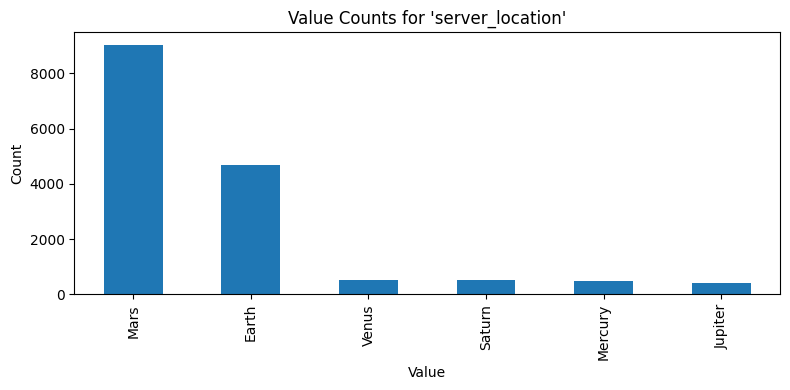

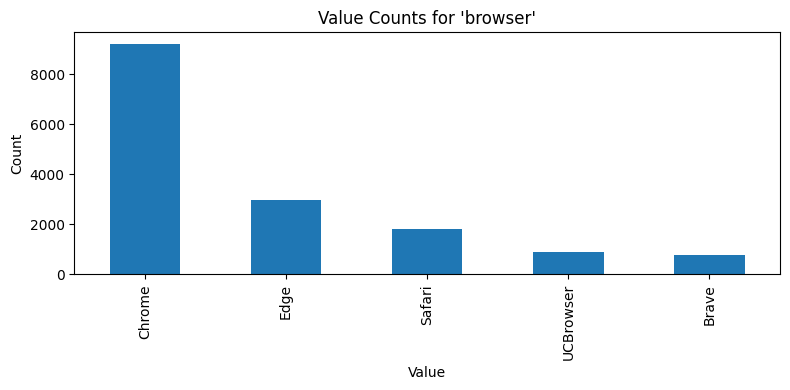

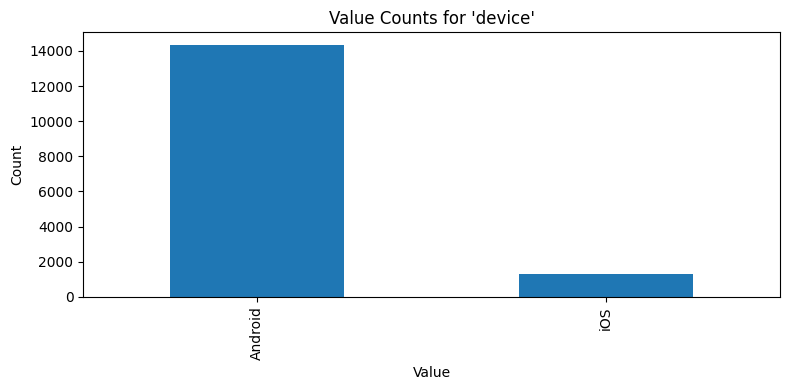

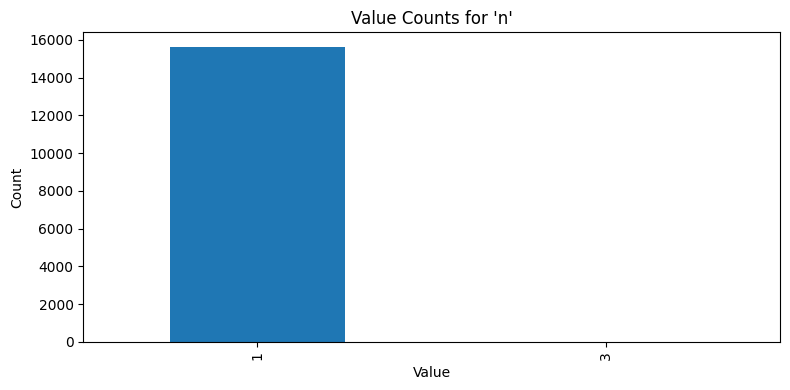

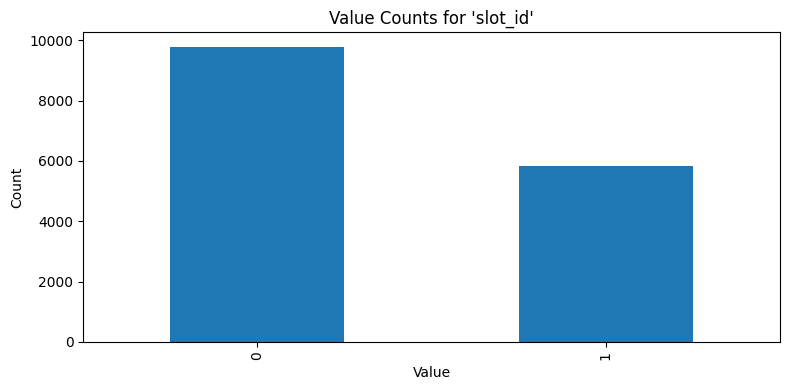

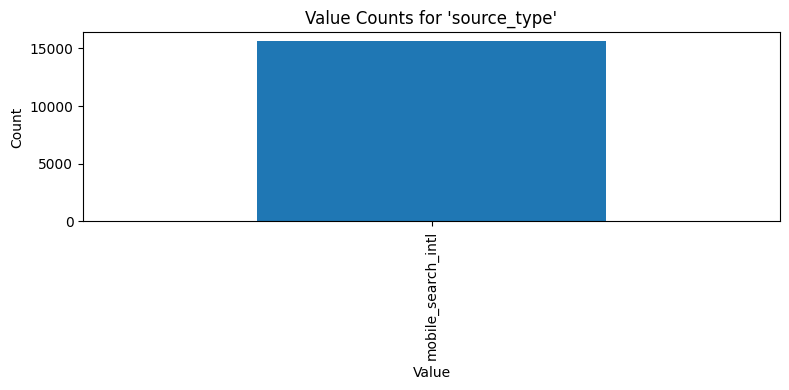

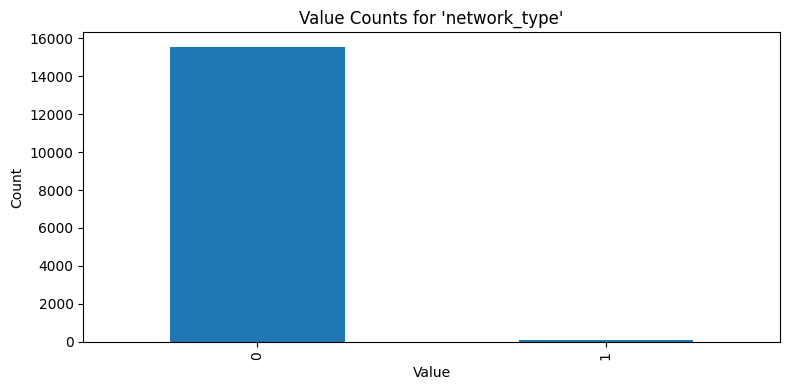

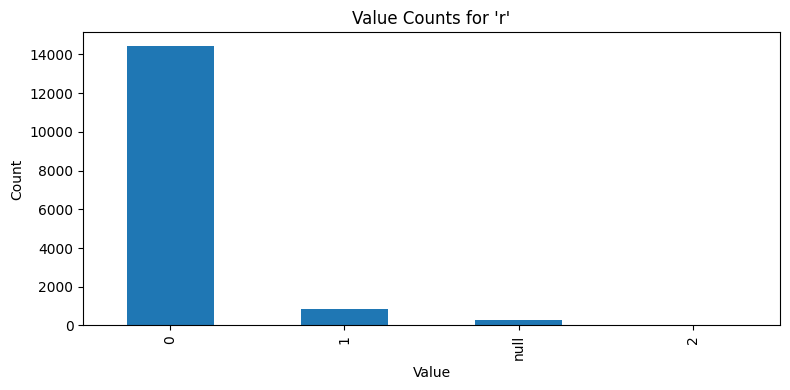

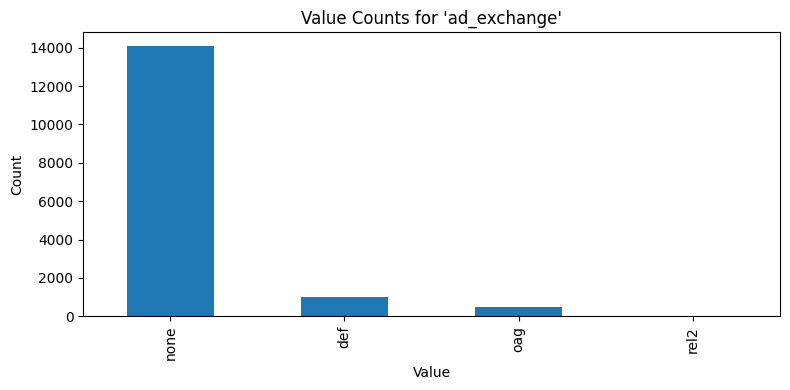

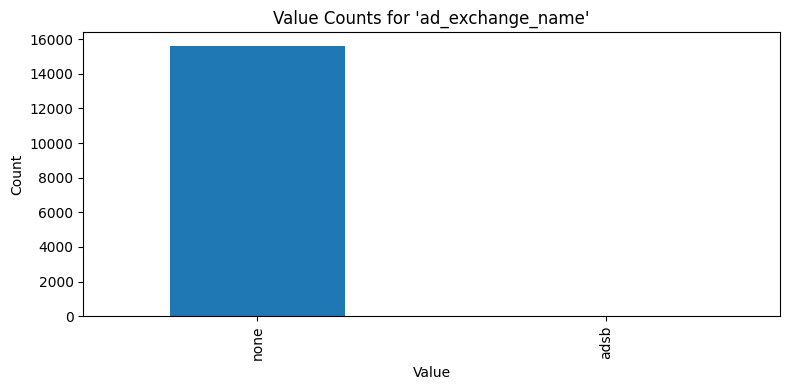

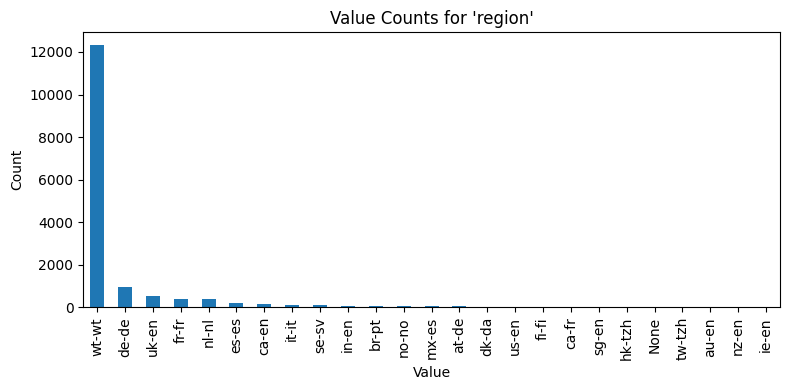

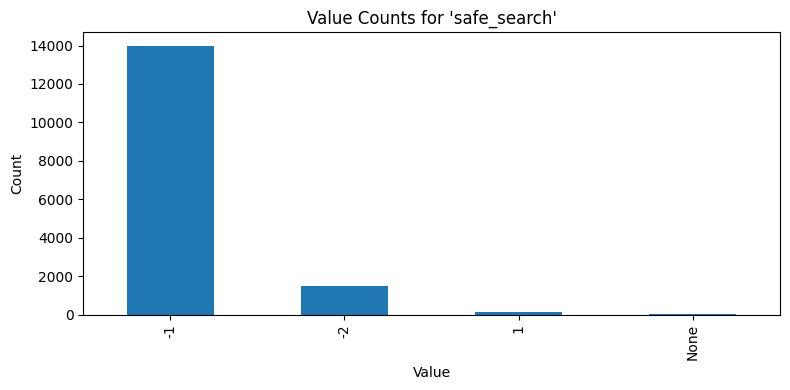

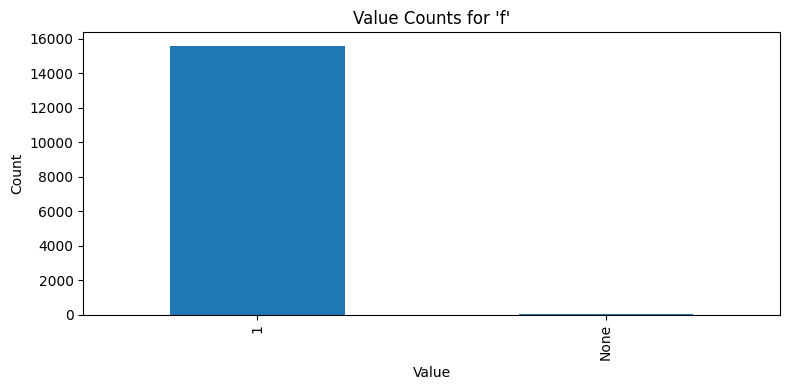

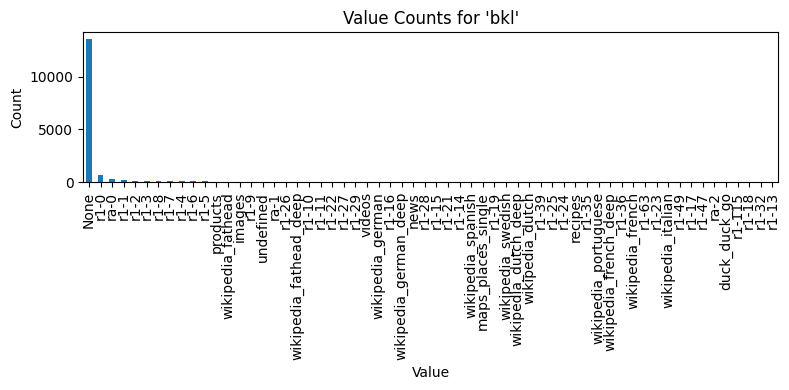

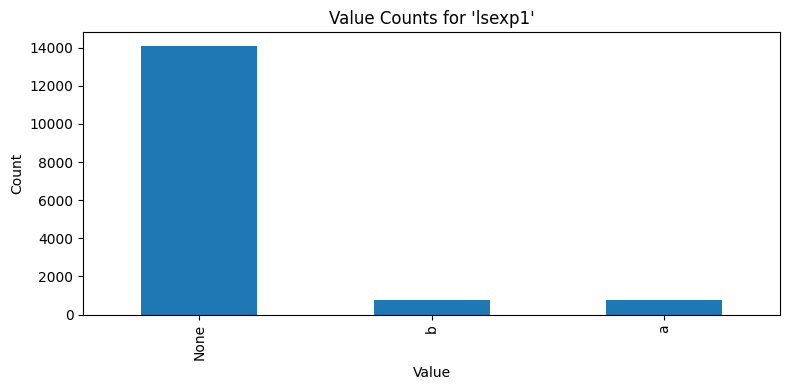

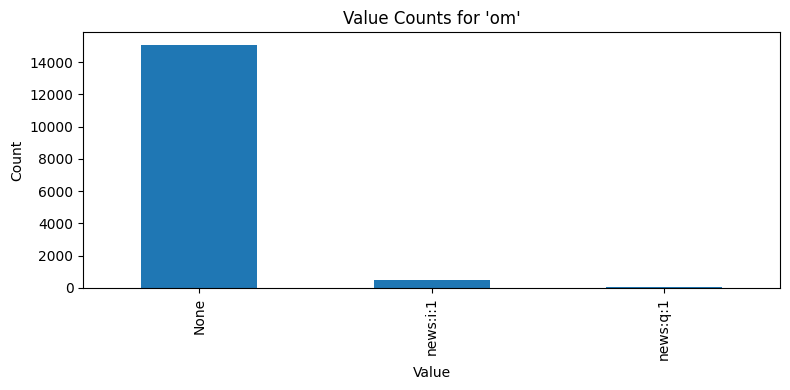

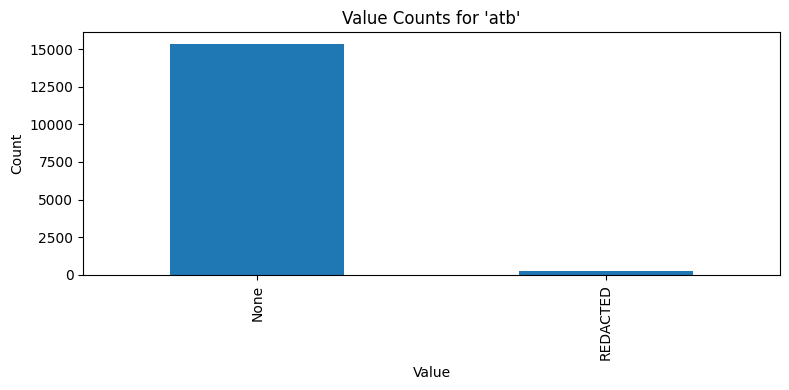

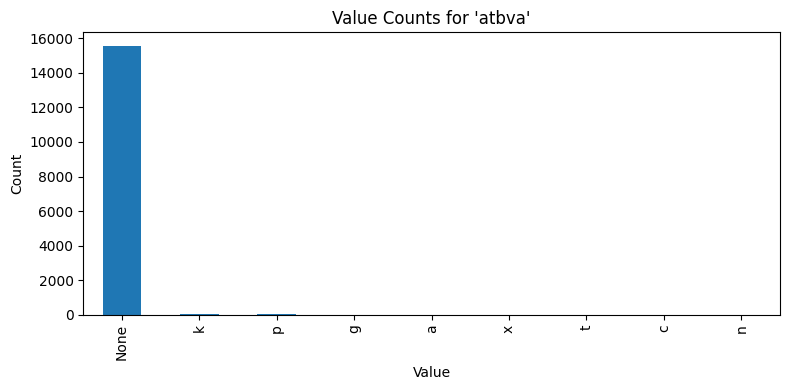

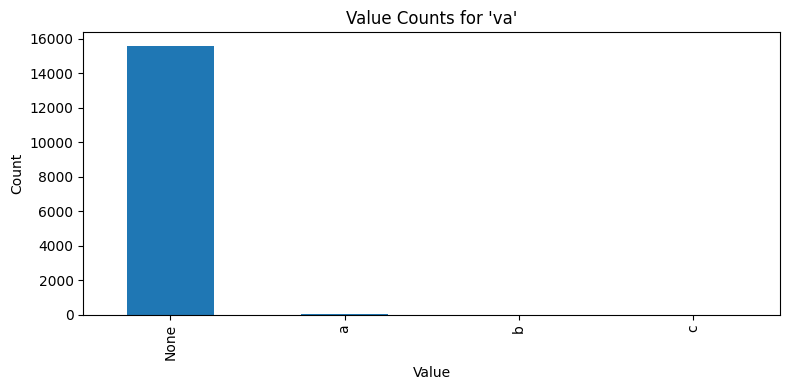

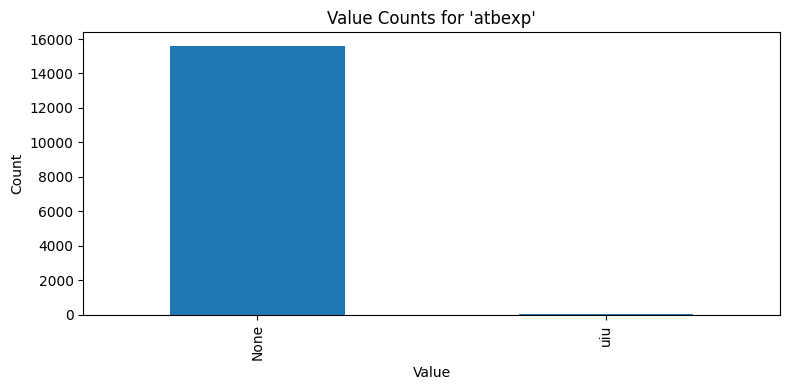

In [15]:
def plot_value_counts(df):
    """
    Plots value counts for each column in the DataFrame.
    """
    for col in df.columns:
        if col not in ['date_time', 'clicked_ad', 'time_to_click', 'search_term', 'country']:
            plt.figure(figsize=(8, 4))
            df[col].value_counts(dropna=False).plot(kind='bar')
            plt.title(f"Value Counts for '{col}'")
            plt.xlabel("Value")
            plt.ylabel("Count")
            plt.tight_layout()
            plt.show()

plot_value_counts(data)

In [16]:
data.safe_search.value_counts(normalize=True)

safe_search
-1    0.896207
-2    0.093734
1     0.010059
Name: proportion, dtype: float64

## Region vs Time to click histogram

<Axes: title={'center': 'Region vs Time to click (Only regions with atleast 100 clicks)'}, xlabel='region', ylabel='time_to_click'>

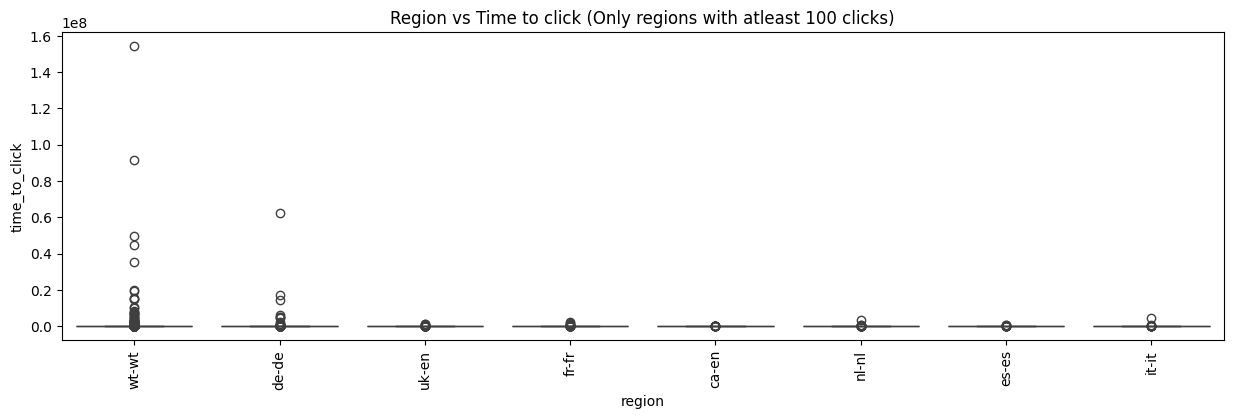

In [17]:
plt.figure(figsize=(15, 4))
plt.title('Region vs Time to click (Only regions with atleast 100 clicks)')
plt.xticks(rotation=90)
sns.boxplot(x=data[data.region.isin(data['region'].value_counts()[(data['region'].value_counts()>100)].index)].region, 
            y=data[data.region.isin(data['region'].value_counts()[(data['region'].value_counts()>100)].index)].time_to_click)

In [18]:
data["time_to_click"].quantile([i/10 for i in range(0,11)])

0.0           52.0
0.1         1786.0
0.2         2627.0
0.3         3627.2
0.4         5011.6
0.5         7056.0
0.6        11010.4
0.7        15265.0
0.8        15938.2
0.9        24958.4
1.0    154409906.0
Name: time_to_click, dtype: float64

## Time of hour vs time to click

/var/folders/d_/m_3rnp1173x224lmnx2gl1mh0000gq/T/ipykernel_3968/101162333.py:6: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mean_val = data[data.date_time.dt.hour == i]["time_to_click"].clip(low,high).mean()
/var/folders/d_/m_3rnp1173x224lmnx2gl1mh0000gq/T/ipykernel_3968/101162333.py:7: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('

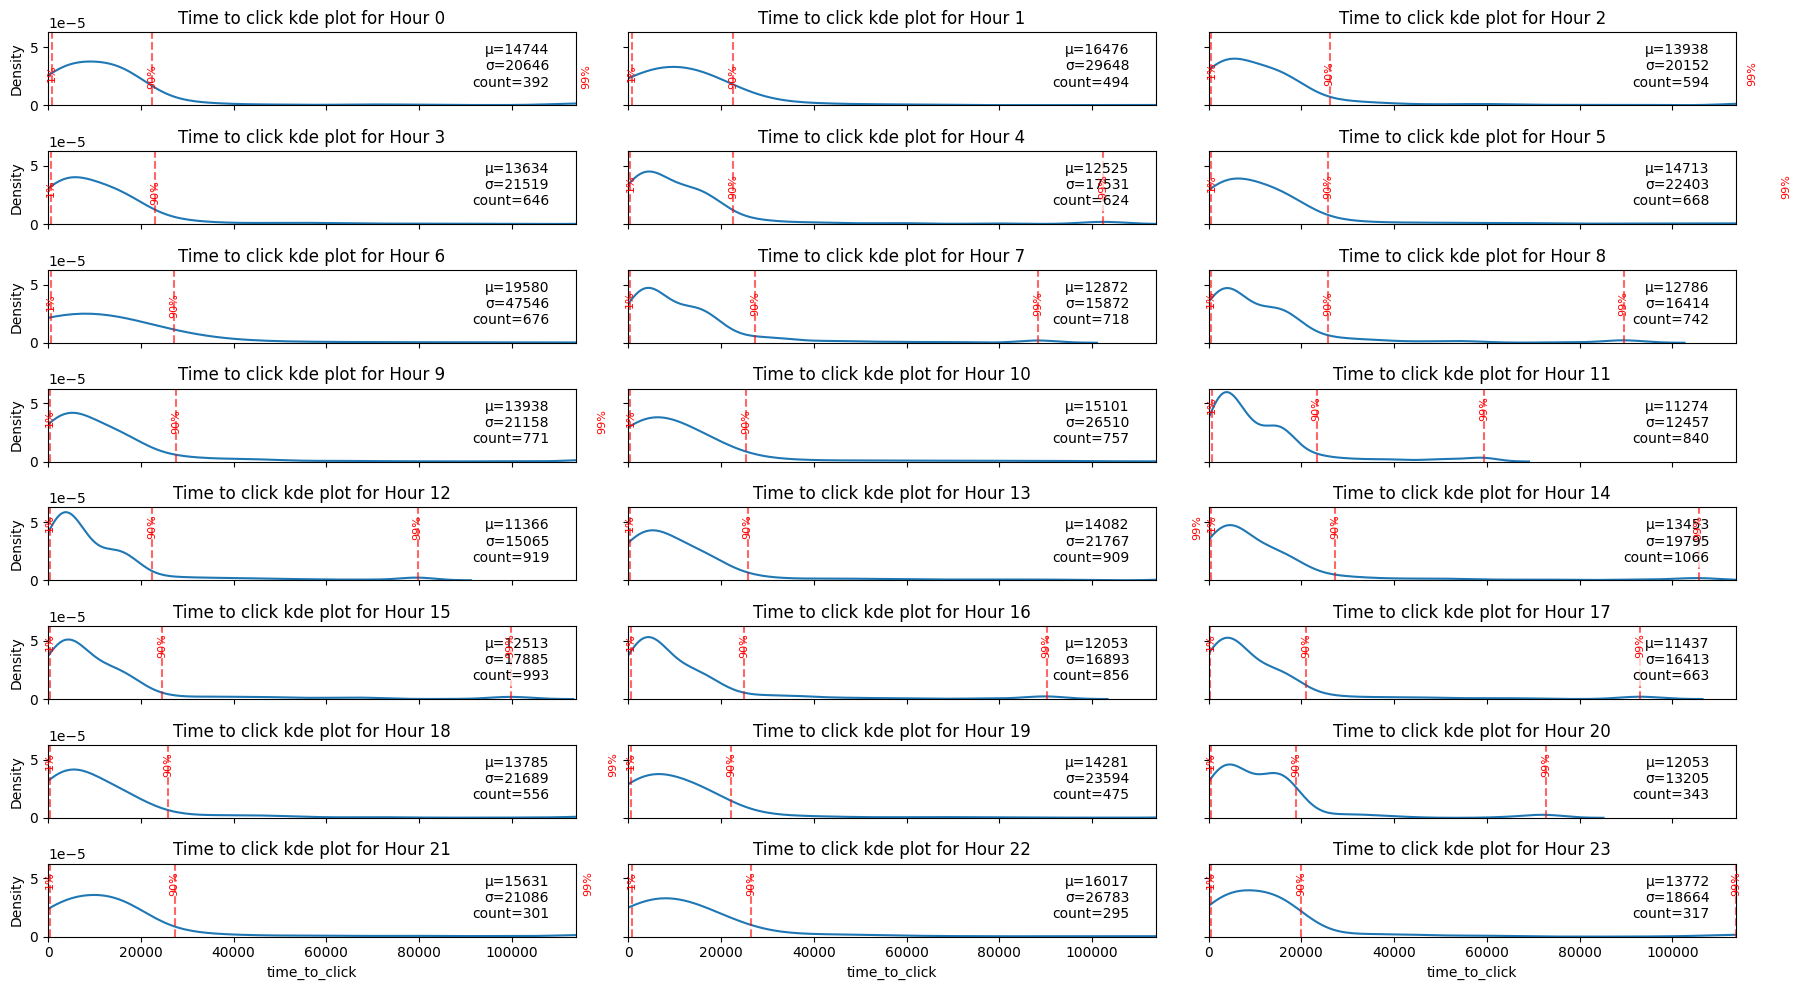

In [19]:
fig, axs = plt.subplots(nrows=8, ncols=3, sharex=True, sharey = True, figsize=(18,10))
axs = axs.flatten()

for i in range(24):
    low, high = 0, np.percentile(data[data.date_time.dt.hour == i]["time_to_click"], 98)
    mean_val = data[data.date_time.dt.hour == i]["time_to_click"].clip(low,high).mean()
    std_val = data[data.date_time.dt.hour == i]["time_to_click"].clip(low,high).std()
    count_val = data[data.date_time.dt.hour == i]["time_to_click"].clip(low,high).shape[0]
    percentiles = np.percentile(data[data.date_time.dt.hour == i]["time_to_click"].clip(low,high), [1, 90, 99])
    sns.kdeplot(data[data.date_time.dt.hour == i]['time_to_click'].clip(low,high), ax=axs[i])
    axs[i].set_title(f'Time to click kde plot for Hour {i}')
    axs[i].set_xlim(0, high)
    
    axs[i].text(
    0.95, 0.85,
    f"μ={mean_val:.0f}\nσ={std_val:.0f}\ncount={count_val:.0f}",
    transform=axs[i].transAxes,
    ha="right", va="top",
    fontsize=10, color="black",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.2")
    )

    for p, val in zip([1, 90, 99], percentiles):
        axs[i].axvline(val, color="red", linestyle="--", alpha=0.6)
        axs[i].text(val, plt.ylim()[1]*0.9, f"{p}%", rotation=90, va='top', ha='center', fontsize=8, color='red')

#plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.35)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)

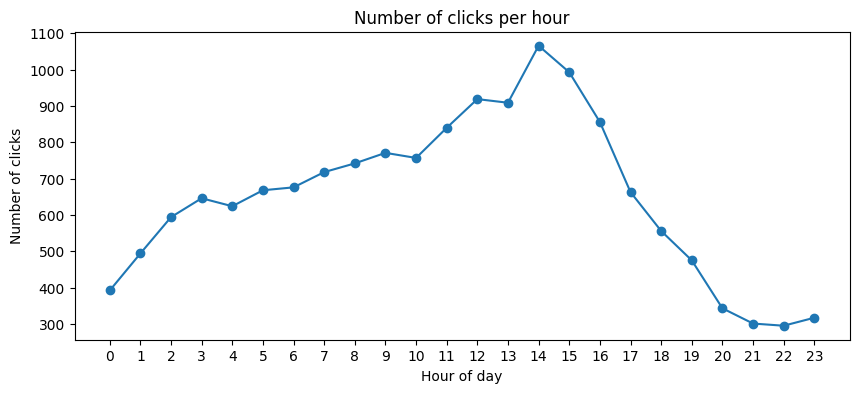

In [20]:
plt.figure(figsize=(10,4))
plt.ylabel('Number of clicks')
plt.xlabel('Hour of day')
plt.xticks(range(24))
plt.title("Number of clicks per hour")
plt.plot(data[['date_time']].groupby(data.date_time.dt.hour).count(), marker = 'o')

## Click heatmap

Text(0.5, 1.0, 'Click Intensity Heatmap by Minute for top 30 search terms')

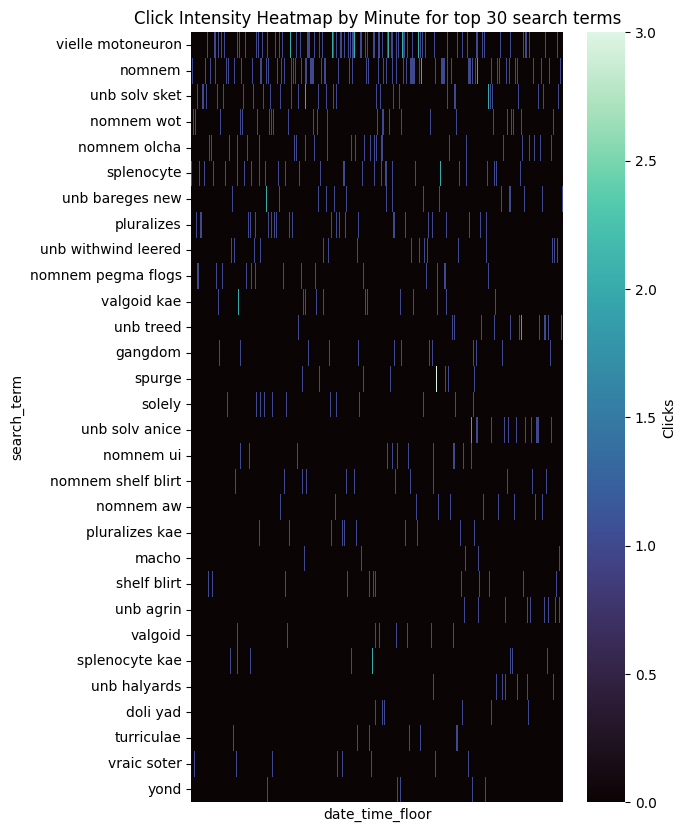

In [21]:
plt.figure(figsize=(6,10))
data['date_time_floor'] = data['date_time'].dt.floor('min')
heatmap_data = data[data.search_term.isin(data.search_term.value_counts()[:30].index.to_list())].groupby(['search_term','date_time_floor']).size().unstack(fill_value=0)
heatmap_data = heatmap_data.loc[heatmap_data.sum(axis=1).sort_values(ascending=False).index]

sns.heatmap(heatmap_data, cmap='mako', cbar_kws={'label': 'Clicks'})
plt.xticks([])
plt.title(f"Click Intensity Heatmap by Minute for top 30 search terms")

# 3. Defining bot clicks

## Identify bot clicks
1. More than 5 clicks for same search terms and clicked ad with max difference between each click being less than 300 seconds
2. Find clicks that are ultra low time to click (Assume less than 1.5s)

In [22]:
fast_time_to_click = duckdb.query(
    """
    select clicked_ad, search_term, date_time, time_to_click
    from data
    where time_to_click < 1500
    """
).to_df()

fast_time_to_click['label'] = 1

In [23]:
bursts = duckdb.query(
    """
    WITH ordered AS (
          SELECT
            search_term,
            clicked_ad,
            date_time,
            time_to_click,
            ROW_NUMBER() OVER (PARTITION BY search_term, clicked_ad ORDER BY date_time) AS rn,
            LAG(date_time) OVER (PARTITION BY search_term, clicked_ad ORDER BY date_time) AS time_lag
          FROM data
),
tagged AS (
          SELECT
            search_term,
            clicked_ad,
            date_time,
            time_lag,
            time_to_click,
            rn,
            date_diff('second', time_lag, date_time) as time_diff,
            SUM(CASE
              WHEN time_lag IS NULL OR date_diff('second', time_lag, date_time) <= 300
                THEN 1 ELSE 0
            END) OVER (PARTITION BY search_term, clicked_ad ORDER BY date_time) AS click_count
          FROM ordered
),
grouped AS (
          SELECT
            tagged.*,
            rn - click_count AS grp_id
          FROM tagged
),
bursts AS (
    SELECT
            search_term,
            clicked_ad,
            grp_id,
            count(*) as streak
          FROM grouped
          WHERE time_diff <= 300
          GROUP BY search_term,
            clicked_ad,
            grp_id
            HAVING count(*) >= 5
)

SELECT g.search_term, g.clicked_ad, g.date_time, g.time_to_click
FROM grouped g
JOIN bursts b
  ON g.search_term = b.search_term
  AND g.clicked_ad = b.clicked_ad
  AND g.grp_id = b.grp_id
ORDER BY g.search_term, g.clicked_ad, g.date_time;
    """
).to_df()

bursts['label'] = 1

# 4. Building ML model

## Create training data 

In [24]:
cols = ['date_time', 'search_term', 'clicked_ad', 'server_location', 'browser', 'device', 'slot_id', 'country', 'safe_search', 'time_to_click']
df = data[cols]
df.dropna(inplace=True)

label = pd.concat([bursts, fast_time_to_click]).reset_index(drop=True).drop_duplicates()

df = df.merge(label, on=['clicked_ad', 'search_term', 'date_time', 'time_to_click'], how='left').fillna(0)

## this feature can cause leakage as label is based off that and we would not have time to click information at the time our model runs to evaluate bots
df.drop('time_to_click', axis = 1, inplace = True)

/var/folders/d_/m_3rnp1173x224lmnx2gl1mh0000gq/T/ipykernel_3968/4181181647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [25]:
df.shape

(15608, 10)

## Feature engineering

In [26]:
## create features from search term
df['term_length'] = df['search_term'].str.len()
df['num_words'] = df['search_term'].str.split().str.len()
df['has_numbers'] = df['search_term'].str.contains(r'\d').astype(int)
df['term_freq'] = df.groupby('search_term')['search_term'].transform('count')

## create features from date time
df['hour_of_day'] = df['date_time'].dt.hour

## type of features
text_features = ['search_term', 'clicked_ad']
cat_features = ['server_location', 'browser', 'device', 'country', 'safe_search', 'hour_of_day', 'slot_id']
num_features = ['term_length', 'num_words', 'has_numbers', 'term_freq']

## Train test split

In [27]:
X = df[text_features + cat_features + num_features]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

## Encoding features

In [28]:
## Text: TF-IDF
text_transformer = ColumnTransformer(
    transformers=[
        ('search_tfidf', TfidfVectorizer(max_features=500, ngram_range=(1,2)), 'search_term'),
        ('clicked_ad_tfidf', TfidfVectorizer(max_features=500, ngram_range=(1,2)), 'clicked_ad')
    ],
    remainder='drop'
)

## Categorical: One-hot encoding
cat_transformer = OneHotEncoder(handle_unknown='ignore')

## Numeric: Use directly (scaling optional)
num_transformer = StandardScaler()

# -------------------------------------------------
# Combine them in a ColumnTransformer
# -------------------------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_features),
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ],
    remainder='drop'   # any extra columns are ignored
)

## Training Model

In [29]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # helpful for imbalanced bot vs human
    ))
])

# -------------------------------------------------
# Train model
# -------------------------------------------------
rf_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Evaluate performance

In [30]:
y_pred = rf_model.predict(X_test)
y_scores = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.71      0.81      4344
         1.0       0.13      0.54      0.21       339

    accuracy                           0.70      4683
   macro avg       0.54      0.63      0.51      4683
weighted avg       0.89      0.70      0.77      4683



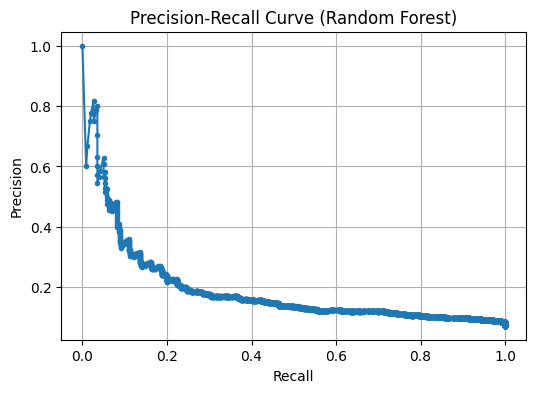

In [31]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve (Random Forest)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

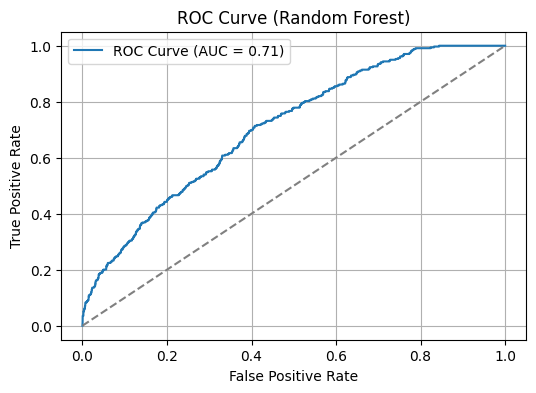

In [32]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve (Random Forest)')
plt.grid(True)
plt.show()

In [33]:
target_precision = 0.9
idx = np.argmin(np.abs(precision - target_precision))
best_threshold = thresholds[idx]
print(f"Best threshold for precision ≈ {target_precision} : {round(best_threshold, 4)}")
print("Precision:", precision[idx])
print("Recall:", recall[idx])

Best threshold for precision ≈ 0.9 : 0.7591
Precision: 0.8181818181818182
Recall: 0.02654867256637168
